In [1]:
import numpy as np
import pandas as pd
import trajectory_planning_helpers as tph
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.utils.track_utils import RaceTrack, CentreLine


In [2]:

def count_corners(kappa, lower_threshold=0.2, corner_threshold=0.6):
    kappa = np.abs(kappa)
    corner_count = 0
    valid_crossing = True
    corner_crossings = []
    for i in range(len(kappa) -1):
        if kappa[i] > corner_threshold and valid_crossing:
            corner_count += 1
            corner_crossings.append(i)
            valid_crossing = False
        if kappa[i] < lower_threshold:
            valid_crossing = True

    return corner_count, corner_crossings

def measure_straight_section(kappa, el_lengths_full, threshold=0.1):
    kappa = np.abs(kappa)
    count = np.where(kappa < threshold)[0]
    straight_length = np.sum(el_lengths_full[count])

    return straight_length



In [10]:
map_file_list = glob.glob(f"../maps/*_centerline.csv")

map_data = []
for map_file in map_file_list:
    track = np.loadtxt(map_file, delimiter=',', skiprows=1)

    map_name = map_file.split("/")[-1].split("_")[0]
    el_lengths = np.linalg.norm(np.diff(track[:, :2], axis=0), axis=1)
    track_length = np.sum(el_lengths)

    psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(track[:, :2], el_lengths, False)

    last_el = np.linalg.norm(track[0, :2] - track[-1, :2])
    full_el = np.append(el_lengths, last_el)
    straight_length = measure_straight_section(kappa, full_el)
    corner_count, corner_crossings = count_corners(kappa)


    mini_dict = {
        "MapName": map_name, 
        "TrackLength": track_length, 
        "StraightLength": straight_length/track_length*100,
        "CornerCount": corner_count,
        }
    map_data.append(mini_dict)

df = pd.DataFrame(map_data)
df = df.sort_values(by=["MapName"])
neat_names = ["Map name", "Track length [m]", "Straight length [\%]", "Number of corners"]
df.rename(columns=dict(zip(df.columns, neat_names)), inplace=True)
df = df.set_index('Map name', drop=True).T
df.rename(columns=str.upper, inplace=True)
df.to_latex("../Data/MapInfo/MapTable.tex", float_format="%.2f")

print(df)



Map name                    AUT         ESP         GBR         MCO
Track length [m]      94.901903  236.928941  201.837814  178.708344
Straight length [\%]  64.919514   58.981774   59.452985   60.597009
Number of corners      7.000000    7.000000    7.000000   16.000000


In [7]:
map_file_list = glob.glob(f"../maps/*_centerline.csv")

map_data = []
for map_file in map_file_list:
    track = np.loadtxt(map_file, delimiter=',', skiprows=1)

    map_name = map_file.split("/")[-1].split("_")[0]
    el_lengths = np.linalg.norm(np.diff(track[:, :2], axis=0), axis=1)
    track_length = np.sum(el_lengths)

    psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(track[:, :2], el_lengths, False)

    total_curvature = np.sum(np.abs(kappa)) # consider integrating over distance...?
    max_curvature = np.max(np.abs(kappa))
    mean_curvature = np.mean(np.abs(kappa))

    last_el = np.linalg.norm(track[0, :2] - track[-1, :2])
    full_el = np.append(el_lengths, last_el)
    straight_length = measure_straight_section(kappa, full_el)
    corner_count, corner_crossings = count_corners(kappa)

    corrected = kappa * full_el
    total_corrected = np.sum(np.abs(corrected))

    mini_dict = {
        "MapName": map_name, 
        "TrackLength": track_length, 
        "TotalCurvature": total_curvature, 
        # "TotalCorrected": total_curvature * track_length,
        "TotalCorrected": total_corrected,
        "MeanCurvature": mean_curvature,
    #  "MaxCurvature": max_curvature, 
        "StraightLength": straight_length/track_length*100,
        "CornerCount": corner_count,
        }
    map_data.append(mini_dict)

df = pd.DataFrame(map_data)
df.CornerCount = df.CornerCount.astype(int)
df = df.sort_values(by=["MapName"])
neat_names = ["Map name", "Track length [m]", "Total curvature", "Total corrected [rad]", "Mean curvature", "Straight length [m]", "Corner count"]
# df.rename(columns=neat_names, inplace=True)
df.rename(columns=dict(zip(df.columns, neat_names)), inplace=True)
df = df.set_index('Map name', drop=True)
# df.set_axis(neat_names, axis=1, inplace=True)
df = df.T
df.rename(columns=str.upper, inplace=True)
df.to_latex("../Data/MapInfo/MapTable.tex", float_format="%.2f")

print(df)

map_df = df.T
map_df = map_df.reset_index()
print(map_df)




Map name                     AUT         ESP         GBR         MCO
Track length [m]       94.901903  236.928941  201.837814  178.708344
Total curvature        82.632845  158.752590  156.193379  171.391243
Total corrected [rad]  16.562513   31.948041   31.538246   34.358199
Mean curvature          0.174331    0.134308    0.155108    0.192143
Straight length [m]    64.919514   58.981774   59.452985   60.597009
Corner count            7.000000    7.000000    7.000000   16.000000
  Map name  Track length [m]  Total curvature  Total corrected [rad]  \
0      AUT         94.901903        82.632845              16.562513   
1      ESP        236.928941       158.752590              31.948041   
2      GBR        201.837814       156.193379              31.538246   
3      MCO        178.708344       171.391243              34.358199   

   Mean curvature  Straight length [m]  Corner count  
0        0.174331            64.919514           7.0  
1        0.134308            58.981774        

KeyError: 'MapName'

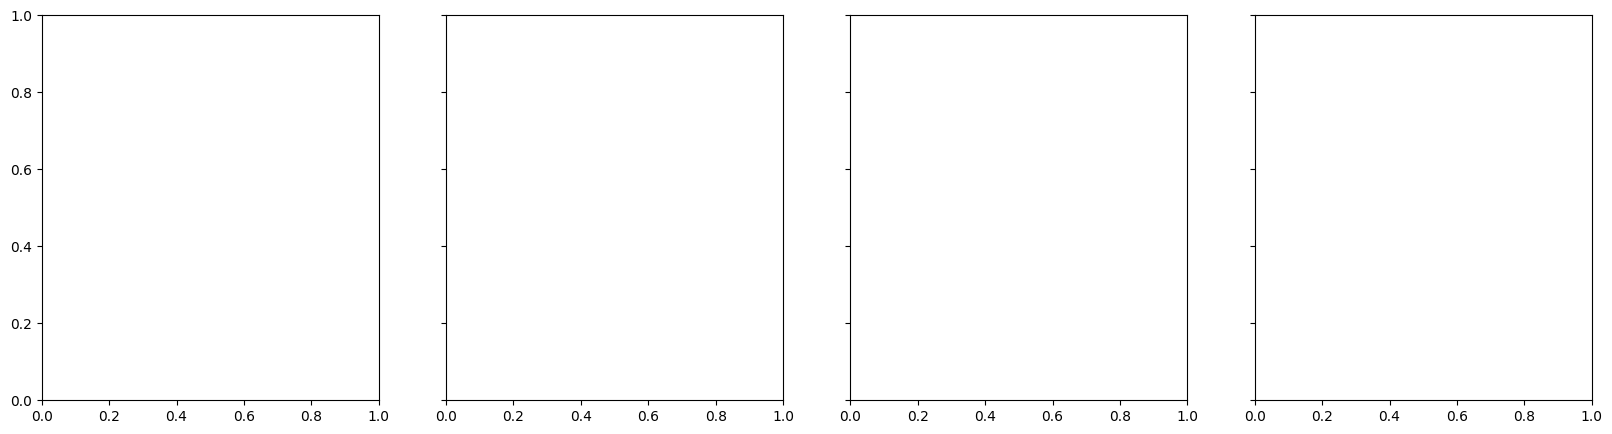

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
map_names = map_df["MapName"].values

for i, map_name in enumerate(map_names):
    map_data = MapData(map_name.lower())
    centre_line = CentreLine(map_name.lower(), directory="../maps/")  
    plt.sca(axs[i])
    map_data.plot_map_img()
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.title(map_name) 

    kappa = np.abs(centre_line.kappa)
    xs, ys = map_data.pts2rc(centre_line.path)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(0, 1.5)
    lc = LineCollection(segments, cmap='Reds', norm=norm)
    lc.set_array(kappa)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)

    plt.plot(xs, ys, 'k--', linewidth=.5)

plt.savefig("../Data/MapInfo.svg", bbox_inches='tight')




(1182,)
(1182, 2)


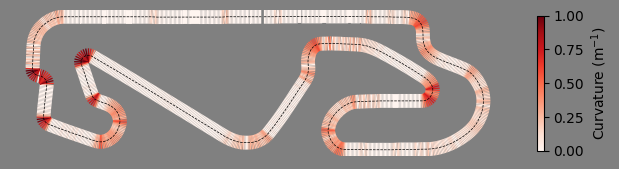

In [ ]:
map_name = "esp"
fig, axs = plt.subplots(1, 1, figsize=(8, 2.5), facecolor='gray')

centre_line = CentreLine(map_name.lower(), directory="../maps/")  
plt.axis('off')
axs.set_aspect('equal')

kappa = np.abs(centre_line.kappa)
print(kappa.shape)
print(centre_line.path.shape)

pts = centre_line.path.reshape(-1, 1, 2)
segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
norm = plt.Normalize(0, 1.)
lc = LineCollection(segments, cmap='Reds', norm=norm)
lc.set_array(kappa)
lc.set_linewidth(10)
line = plt.gca().add_collection(lc)
cb = plt.colorbar(line, ax=axs, shrink=0.7, label="Curvature (m$^{-1}$)")

plt.plot(centre_line.path[:, 0], centre_line.path[:, 1], 'k--', linewidth=.5)

file_name = f"../Data/MapInfo/CurvatureHeatMap_{map_name}"
plt.savefig(f"{file_name}.svg", bbox_inches='tight')
plt.savefig(f"{file_name}.pdf", bbox_inches='tight')




Corner count: 7
Straight length: 139.74489323742296 m


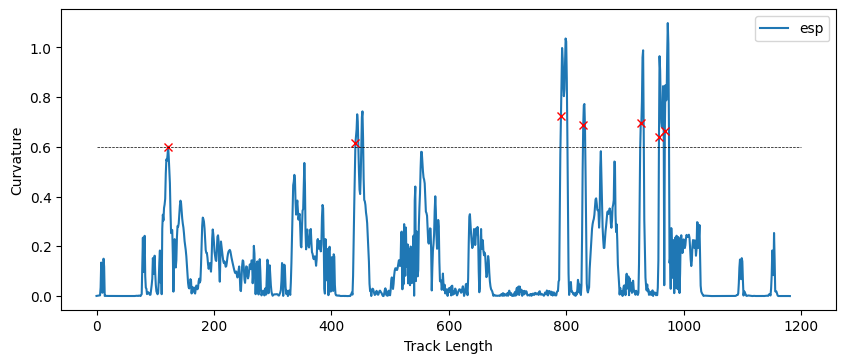

In [ ]:
map_names = map_df["MapName"].values
fig = plt.figure(figsize=(10, 3.9))

def count_corners(kappa, lower_threshold=0.2, corner_threshold=0.6):
    corner_count = 0
    valid_crossing = True
    corner_crossings = []
    for i in range(len(kappa) -1):
        if kappa[i] > corner_threshold and valid_crossing:
            corner_count += 1
            corner_crossings.append(i)
            valid_crossing = False
        if kappa[i] < lower_threshold:
            valid_crossing = True

    return corner_count, corner_crossings

def measure_straight_section(kappa, el_lengths_full, threshold=0.1):
    count = np.where(kappa < threshold)[0]
    straight_length = np.sum(el_lengths_full[count])

    return straight_length


map_names = ["esp"]
for i, map_name in enumerate(map_names):
    centre_line = CentreLine(map_name.lower(), directory="../maps/")  
    kappa = np.abs(centre_line.kappa)
    corner_count, corner_crossings = count_corners(kappa)
    print(f"Corner count: {corner_count}")

    last_el = np.linalg.norm(centre_line.path[0] - centre_line.path[-1])
    full_el = np.append(centre_line.el_lengths, last_el)
    straight_length = measure_straight_section(kappa, full_el)
    print(f"Straight length: {straight_length} m")

    plt.plot(kappa, label=map_name)
    plt.legend()
    plt.xlabel("Track Length")
    plt.ylabel("Curvature")
    plt.plot(corner_crossings, kappa[corner_crossings], 'rx')

    level = 0.6
    plt.plot([0, 1200], [level, level], 'k--', linewidth=.5)




